# 12 modes PBC Quantum Linear Optics reservoir applied to wind-produced energy data and NARMA sequence

In [88]:
# Libraries importation

import matplotlib.pyplot as plt # for plotting
import numpy as np # for numerical operations
import pandas as pd # for data manipulation
import perceval as pcvl # for perceval algorithm
from sklearn.model_selection import train_test_split # for splitting data
from sklearn.linear_model import LinearRegression # for linear regression
from sklearn.preprocessing import PolynomialFeatures # for polynomial regression
from tqdm import tqdm # for progress bar

In [89]:
# Reservoir class

class PhotonicReservoirSimulator:
    def __init__(self, m, t_max, overlapping=False):
        self.m = m  # Number of modes
        self.t_max = t_max  # Number of time layerse
        self.overlapping = overlapping
        self.layers = []  # Stores generated layers
    def generate_and_store_layers(self):
        """Generate and store layers up to max_t."""
        self.layers = [self.full_layer(t) for t in range(self.t_max)]
    def set_circuit_with_stored_layers(self, num_layers=None):
        """Creates a circuit using the first num_layers from stored layers."""
        if num_layers is None:
            num_layers = self.t_max
        # Generate additional layers if needed
        if num_layers > len(self.layers):
            missing_layers = num_layers - len(self.layers)
            print(f"WARNING: Requested more layers than generated. Generating {missing_layers} more layers...")
            for t in tqdm(range(len(self.layers), len(self.layers) + missing_layers), desc="Generating layers"):
                self.layers.append(self.full_layer(t))
        # Create the circuit using the stored layers
        circuit = pcvl.Circuit(self.m)
        for layer in self.layers[:num_layers]:
            circuit = circuit.add(0, layer)
        #print("setting self.circuit...")
        self.circuit = circuit
    def set_circuit_with_memory(self, memory_length, num_layers):
        """Creates a circuit using layers starting from num_layer - memory up to num_layer."""
        # Adjust starting point based on memory
        start_layer = max(num_layers - memory_length, 0)
        # Generate additional layers if needed
        if num_layers > len(self.layers):
            missing_layers = num_layers - len(self.layers)
            print(f"WARNING: Requested more layers than generated. Generating {missing_layers} more layers...")
            for t in tqdm(range(len(self.layers), num_layers), desc="Generating layers"):
                self.layers.append(self.full_layer(t))
        # Create the circuit using the specified range of stored layers
        circuit = pcvl.Circuit(self.m)
        for layer in self.layers[start_layer:num_layers]:
            circuit = circuit.add(0, layer)
        self.circuit = circuit
    def U_ij_t(self, i, j, t=0):
        """Returns the unitary acting on mode i and j."""
        return (pcvl.Circuit(2, name=f"U_{i}{j}_t{t}")
                .add(0, pcvl.PS(phi=pcvl.P(f"phi_tl_{i}{j}_t{t}")))
                .add(1, pcvl.PS(phi=pcvl.P(f"phi_bl_{i}{j}_t{t}")))
                .add(0, pcvl.BS(theta=pcvl.P(f'theta_{i}{j}_t{t}')))
                .add(0, pcvl.PS(phi=pcvl.P(f"phi_tr_{i}{j}_t{t}")))
                .add(1, pcvl.PS(phi=pcvl.P(f"phi_br_{i}{j}_t{t}"))))
    def full_layer(self, t=0):
        """Generate one full time layer"""
        layer = pcvl.Circuit(self.m)
        if self.overlapping:
            for i in range(self.m - 1):
                layer = layer.add(i, self.U_ij_t(i, (i + 1), t))
        else:
            if self.m % 2 != 0:
                print("WARNING: Number of modes is not even; last mode will be ignored.")
            for i in range(self.m // 2):
                layer = layer.add(2 * i, self.U_ij_t(2 * i, 2 * i + 1, t))
        return layer
    def create_circuit(self):
        """Creates a circuit with t_max layers."""
        circuit = pcvl.Circuit(self.m)
        for t in range(self.t_max):
            circuit = circuit.add(0, self.full_layer(t))
        return circuit
    def generate_rndm_param_matrix(self, num_layers=None):
        """Generates a random parameter matrix of size (t, num_parameters)."""
        if num_layers is None:
            print("WARNING: No number of layers provided for rndm data matrix. Using t_max.")
            num_layers = self.t_max
        num_parameters = len(self.circuit.get_parameters())
        # Random dataset of angles
        return np.random.rand(num_layers, num_parameters//num_layers)*2*np.pi
    def set_circuit_parameters(self, parameter_matrix):
        """Set the parameters of the circuit to the values in the matrix.
        Args:
            parameter_matrix (np.ndarray): A matrix of size (t, num_parameters).
        Description:
            The parameter matrix is flattened to match the list of parameters.
            The parameters are set in the order they appear in the circuit.
        """
        flattened_params = parameter_matrix.flatten()
        params = self.circuit.get_parameters()
        assert len(params) == len(
            flattened_params), f"Parameter length mismatch. Expected {len(params)} parameters, got {len(flattened_params)}."
        for param, value in zip(params, flattened_params):
            param.set_value(value)
    def calculate_mode_expectations(self, input_state: pcvl.BasicState = None):
        if input_state is None:
            print("WARNING: No input state provided. Using the vacuum state.")
            input_state = pcvl.BasicState([0] * self.m)
        backend = pcvl.BackendFactory.get_backend("SLOS")
        backend.set_circuit(self.circuit)
        backend.set_input_state(input_state)
        prob_distribution = backend.prob_distribution()
        # processor = pcvl.Processor("CliffordClifford2017", self.circuit)
        # processor.with_input(input_state)
        # sampler = pcvl.algorithm.Sampler(processor)
        # prob_distribution = sampler.probs()["results"]
        expectations = [0.0 for _ in range(self.m)]
        for state, probability in prob_distribution.items():
            for mode in range(self.m):
                expectations[mode] += state[mode] * probability
        return expectations
    def sequential_expectation_calculation(self, data, input_state):
        # Initialize an empty matrix to store expectation values
        expectations_matrix = []
        for t in tqdm(range(self.t_max), desc="Processing time steps"):
            # Generate a circuit with num_layers = t
            self.set_circuit_with_stored_layers(num_layers=t)
            # Take the first t rows of the data matrix
            params_subset = data[:t]
            # Set the parameters of the circuit
            self.set_circuit_parameters(params_subset)
            # Evaluate the expectation values
            expectation_values = self.calculate_mode_expectations(input_state)
            # Append the expectation values to the matrix
            expectations_matrix.append(expectation_values)
        return np.array(expectations_matrix)
    def sequential_expectation_with_memory(self, data, input_state, memory_length):
        """Calculates sequential expectation values using a specified number of memory layers."""
        # Initialize an empty matrix to store expectation values
        expectations_matrix = []
        for t in tqdm(range(self.t_max), desc="Processing time steps"):
            # Generate a circuit with memory layers starting from t - memory
            self.set_circuit_with_memory(memory_length=memory_length, num_layers=t)
            # Take the latest 'memory' rows of the data matrix up to the current time step t
            # Ensure we don't go below index 0
            start_index = max(0, t - memory_length)
            params_subset = data[start_index:t]
            # Set the parameters of the circuit
            self.set_circuit_parameters(params_subset)
            # Evaluate the expectation values
            expectation_values = self.calculate_mode_expectations(input_state)
            # Append the expectation values to the matrix
            expectations_matrix.append(expectation_values)
        return np.array(expectations_matrix)
    def sequential_expectation_with_memory_and_decay(self, data, input_state, memory_length, decay_rate=None):
        """Calculates sequential expectation values using a specified number of memory layers and a decay parameter."""
        # Initialize an empty matrix to store expectation values
        expectations_matrix = []
        for t in tqdm(range(self.t_max), desc="Processing time steps"):
            # Generate a circuit with memory layers starting from t - memory
            self.set_circuit_with_memory(memory_length=memory_length, num_layers=t)
            # Take the latest 'memory' rows of the data matrix up to the current time step t
            # Ensure we don't go below index 0
            start_index = max(0, t - memory_length)
            params_subset = data[start_index:t]
            if decay_rate is not None:
                # Apply decay to the parameters subset
                for i in range(len(params_subset)):
                    decay_factor = (1 / (decay_rate * (len(params_subset) - i) + 1))
                    params_subset[i] *= decay_factor
            # Set the parameters of the circuit
            self.set_circuit_parameters(params_subset)
            # Evaluate the expectation values
            expectation_values = self.calculate_mode_expectations(input_state)
            # Append the expectation values to the matrix
            expectations_matrix.append(expectation_values)
        return np.array(expectations_matrix)

# Wind-produced energy data

In [90]:
df = pd.read_csv("wind_data_fr_2021.csv", sep=";") # csv loading

da = np.array(df["Eolien (MW)"]) # np array creation from csv

da_scaled = da[:100] # scaled array for comparison

da = da.reshape(-1,1) # reshaping the array
da = np.tile(da, (1, 55)) # tiling the array to n = 5*(m-1) where m is the number of modes
da = da[:100] # slicing the array to match the scaled array

Text(0.5, 1.0, 'Wind power production (50 hours)')

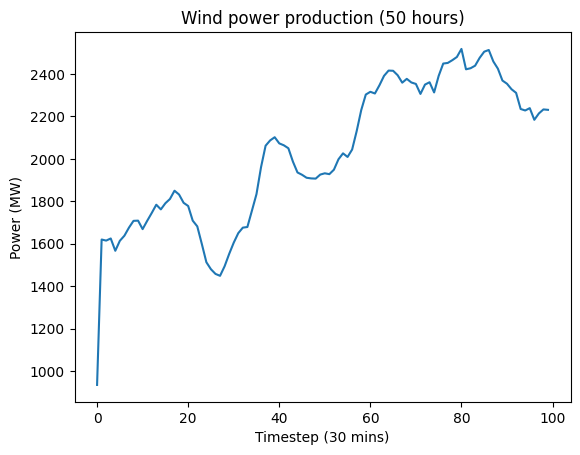

In [91]:
# plot data
plt.plot(da_scaled)
# legend x axis
plt.xlabel("Timestep (30 mins)")
# legend y axis
plt.ylabel("Power (MW)")
# title
plt.title("Wind power production (50 hours)")

In [92]:
simulator = PhotonicReservoirSimulator(12, 100, overlapping=True) # reservoir creation

_ = simulator.set_circuit_with_stored_layers() # setting the circuit

Generating layers: 100%|██████████| 100/100 [00:00<00:00, 163.39it/s]


In [93]:
input_state = pcvl.BasicState([1]*1 + [0]*11) # input state creation

output_array = simulator.sequential_expectation_calculation(da, input_state) # output array creation

Processing time steps: 100%|██████████| 100/100 [00:06<00:00, 15.45it/s]


# Linear regression

Text(0.5, 1.0, 'Linear Regression (Wind) (50 hours) (100% train)')

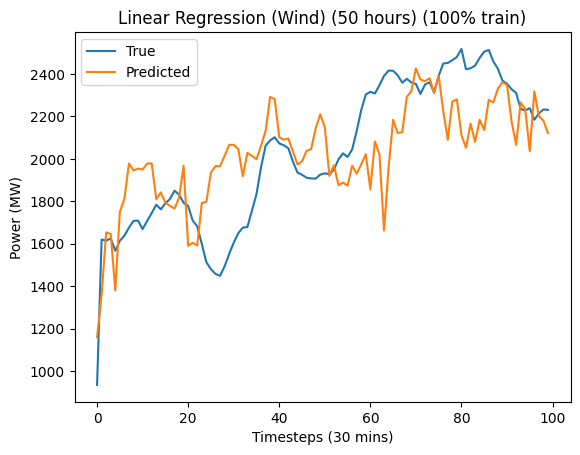

In [94]:
reg = LinearRegression().fit(output_array, da_scaled) # linear regression fit
reg.predict(output_array) # prediction

# plot true data
plt.plot(da_scaled, label="True")
# plot predicted data
plt.plot(reg.predict(output_array), label="Predicted")
# legend axis x
plt.xlabel("Timesteps (30 mins)")
# legend axis y
plt.ylabel("Power (MW)")
# legend
plt.legend()
# title
plt.title("Linear Regression (Wind) (50 hours) (100% train)")

In [95]:
# Splitting the data

X_train, X_test, y_train, y_test = train_test_split(output_array, da_scaled, test_size=0.5)

Text(0.5, 1.0, 'Linear Regression (Wind) (25 hours) (50% train, 50% test)')

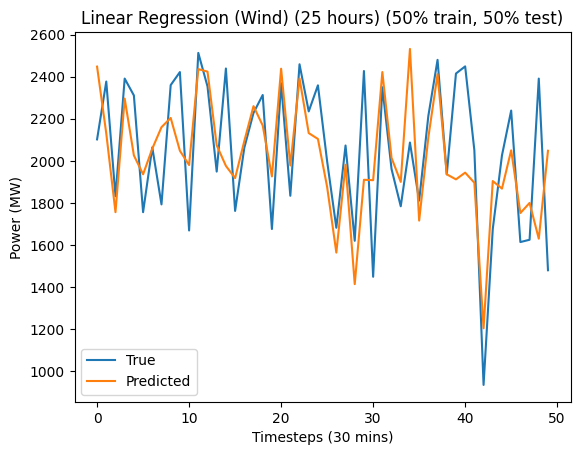

In [96]:
reg = LinearRegression().fit(X_train, y_train) # linear regression fit
reg.predict(X_test) # prediction

# plot true data
plt.plot(y_test, label="True")
# plot predicted data
plt.plot(reg.predict(X_test), label="Predicted")
# legend axis x
plt.xlabel("Timesteps (30 mins)")
# legend axis y
plt.ylabel("Power (MW)")
# legend
plt.legend()
# title
plt.title("Linear Regression (Wind) (25 hours) (50% train, 50% test)")

# Polynomial regression

Text(0.5, 1.0, 'Polynomial Regression (Wind) (25 hours) (50% train, 50% test)')

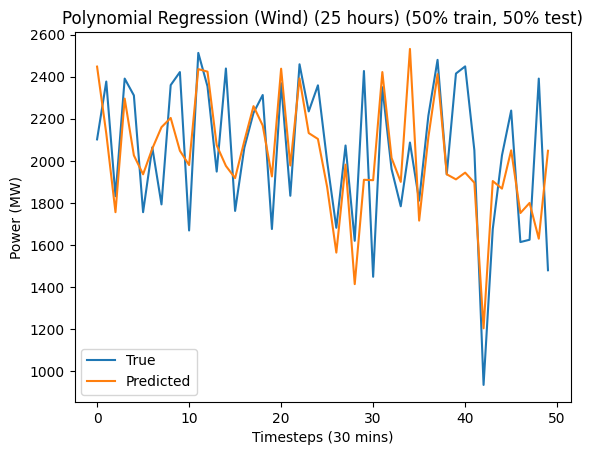

In [97]:
poly = PolynomialFeatures(2) # set the degree of the polynomial
output_array_poly = poly.fit_transform(output_array) # transform the output array

reg = LinearRegression().fit(X_train, y_train) # linear regression fit
reg.predict(X_test) # prediction

# plot true data
plt.plot(y_test, label="True")
# plot predicted data
plt.plot(reg.predict(X_test), label="Predicted")
# legend axis x
plt.xlabel("Timesteps (30 mins)")
# legend axis y
plt.ylabel("Power (MW)")
# legend
plt.legend()
# title
plt.title("Polynomial Regression (Wind) (25 hours) (50% train, 50% test)")

# NARMA sequence data

In [98]:
# NARMA functions

# Input generator

# a, b, g: input parameters
# ct: number of timesteps
def u_generator(a, b, g, ct):
    u = [] # input vector
    # loop between 1 and ct
    for t in range(1, ct):
        b1 = np.sin((2*np.pi*a*t)/ct) # first term
        b2 = np.sin((2*np.pi*b*t)/ct) # second term
        b3 = np.sin((2*np.pi*g*t)/ct) # third term
        u.append(0.1 * ((b1 * b2 * b3) + 1)) # append formula result to u
    return u # return input vector

# a, b, g: input parameters
# d: initial value
# n: delay
# u: input vector
def y_generator(a, b, g, d, n, u):
    y = [d] # output vector
    # loop between 1 and the length of u
    for i in range(1, len(u)):
        n_temp = 0 # temporary variable
        # if the length of y is less than n + 1
        if len(y) < n + 1:
            n_temp = len(y) # set n_temp to the length of y
            s = 0 # temporary variable
            # loop between 0 and the length of y minus 1
            for j in range(n_temp - 1):
                s += y[i - j - 1] # sum of y
        else:
            s = 0 # temporary variable
            # loop between 0 and n - 1
            for j in range(n - 1):
                s += y[i - j - 1] # sum of y
        b1 = a * y[i - 1] # first term
        b2 = b * y[i - 1] * s # second term
        # if the length of y is less than n + 1
        if len(y) < n - 1:
            n_temp = len(y) # set n_temp to the length of y
            b3 = g * u[i - 1 - n_temp + 1] * u[i - 1] # third term
        else:
            b3 = g * u[i - n + 1] * u[i-1] # third term
        y.append(b1 + b2 + b3 + d) # append formula result to y
    return y # return output vector

In [99]:
# input generation
u = u_generator(2.11, 3.73, 4.11, 101)

# output generation
y = y_generator(0.3, 0.05, 1.5, 0.1, 5, u)

da = np.array(y) # np array creation from csv

da_scaled = da[:100] # scaled array for comparison

da = da.reshape(-1,1) # reshaping the array
da = np.tile(da, (1, 55)) # tiling the array to n = 5*(m-1) where m is the number of modes
da = da[:100] # slicing the array to match the scaled array

Text(0.5, 1.0, 'NARMA-5 (100 timesteps)')

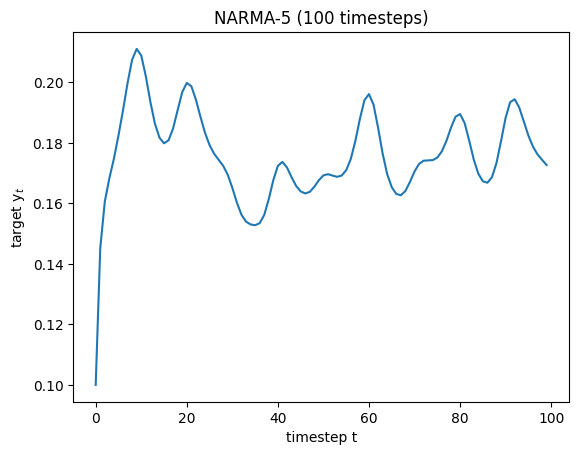

In [100]:
# plot NARMA data
plt.plot(da_scaled)
# legend axis x
plt.xlabel('timestep t')
# legend axis y
plt.ylabel('target y$_t$')
# title
plt.title('NARMA-5 (100 timesteps)')

In [101]:
simulator = PhotonicReservoirSimulator(12, 100, overlapping=True) # reservoir creation

_ = simulator.set_circuit_with_stored_layers() # setting the circuit

Generating layers: 100%|██████████| 100/100 [00:00<00:00, 136.19it/s]


In [102]:
input_state = pcvl.BasicState([1]*1 + [0]*11) # input state creation

output_array = simulator.sequential_expectation_calculation(da, input_state) # output array creation

Processing time steps: 100%|██████████| 100/100 [00:06<00:00, 15.48it/s]


# Linear regression

Text(0.5, 1.0, 'Linear Regression (NARMA) (100 timesteps) (100% train)')

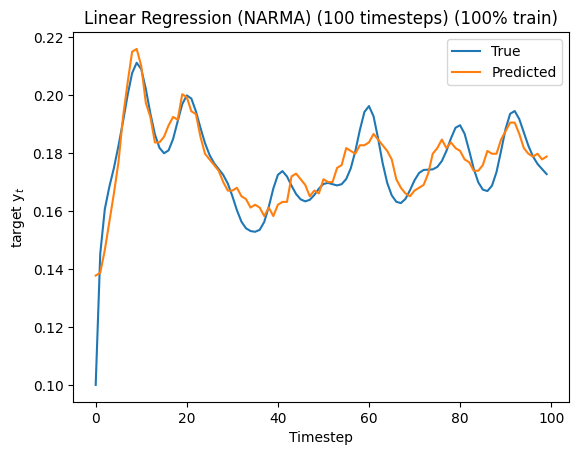

In [103]:
reg = LinearRegression().fit(output_array, da_scaled) # linear regression fit
reg.predict(output_array) # prediction

# plot true data
plt.plot(da_scaled, label="True")
# plot predicted data
plt.plot(reg.predict(output_array), label="Predicted")
# legend axis x
plt.xlabel("Timestep")
# legend axis y
plt.ylabel("target y$_t$")
# legend
plt.legend()
# title
plt.title("Linear Regression (NARMA) (100 timesteps) (100% train)")

In [104]:
# Splitting the data

X_train, X_test, y_train, y_test = train_test_split(output_array, da_scaled, test_size=0.5)

Text(0.5, 1.0, 'Linear Regression (NARMA) (50 timesteps) (50% train, 50% test)')

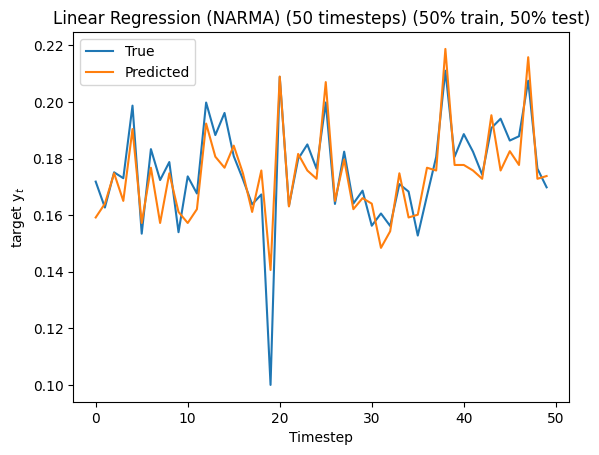

In [105]:
reg = LinearRegression().fit(X_train, y_train) # linear regression fit
reg.predict(X_test) # prediction

# plot true data
plt.plot(y_test, label="True")
# plot predicted data
plt.plot(reg.predict(X_test), label="Predicted")
# legend axis x
plt.xlabel("Timestep")
# legend axis y
plt.ylabel("target y$_t$")
# legend
plt.legend()
# title
plt.title("Linear Regression (NARMA) (50 timesteps) (50% train, 50% test)")

# Polynomial regression

Text(0.5, 1.0, 'Polynomial Regression (NARMA) (50 timesteps) (50% train, 50% test)')

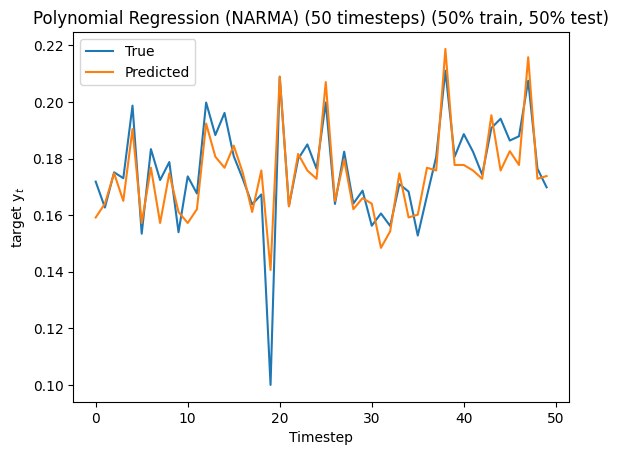

In [106]:
poly = PolynomialFeatures(2) # set the degree of the polynomial
output_array_poly = poly.fit_transform(output_array) # transform the output array

reg = LinearRegression().fit(X_train, y_train) # linear regression fit
reg.predict(X_test) # prediction

# plot true data
plt.plot(y_test, label="True")
# plot predicted data
plt.plot(reg.predict(X_test), label="Predicted")
# legend axis x
plt.xlabel("Timestep")
# legend axis y
plt.ylabel("target y$_t$")
# legend
plt.legend()
# title
plt.title("Polynomial Regression (NARMA) (50 timesteps) (50% train, 50% test)")